In [1]:
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from pyspark import SparkContext, SparkConf
sc = SparkContext('local[*]')

In [2]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

import pyspark_csv as pycsv
sc.addPyFile('pyspark_csv.py')
plaintext_rdd = sc.textFile('propiedades-clean.csv')
dataframe = pycsv.csvToDataFrame(sqlContext, plaintext_rdd)
data = dataframe.rdd

In [3]:
i = 0
for row in dataframe:
    print(i, "--->", row)
    i += 1

0 ---> Column<b''>
1 ---> Column<b'created_on'>
2 ---> Column<b'year'>
3 ---> Column<b'currency'>
4 ---> Column<b'description'>
5 ---> Column<b'expenses'>
6 ---> Column<b'floor'>
7 ---> Column<b'geonames_id'>
8 ---> Column<b'id'>
9 ---> Column<b'lat'>
10 ---> Column<b'lon'>
11 ---> Column<b'operation'>
12 ---> Column<b'place_name'>
13 ---> Column<b'place_with_parent_names'>
14 ---> Column<b'price'>
15 ---> Column<b'price_aprox_local_currency'>
16 ---> Column<b'price_aprox_usd'>
17 ---> Column<b'price_per_m2'>
18 ---> Column<b'price_usd_per_m2'>
19 ---> Column<b'property_type'>
20 ---> Column<b'rooms'>
21 ---> Column<b'state_name'>
22 ---> Column<b'surface_covered_in_m2'>
23 ---> Column<b'surface_total_in_m2'>


In [4]:
import re, string, unicodedata
def removePunctuation(text):
    
    text=str(text).lower().strip(' ')
    text=unicodedata.normalize('NFD', text).encode('ascii','ignore')
    text=text.decode('utf-8')
    text=re.sub(r'[^a-zA-Z0-9 ]', '', text)   
    return text



In [5]:
#palabrasYprecio (id,precio por m2,descripcion)
#palabras (descripcion)
palabrasYprecio = data.map(lambda x: (x[8],x[18],removePunctuation(x[4])))
print(palabrasYprecio.count())
palabras = data.map(lambda x: removePunctuation(x[4]))
palabrasYprecio = palabrasYprecio.filter(lambda x: x[1] != None)
print(palabrasYprecio.count())

221341
170495


In [6]:
# buscar las 50 palabras mas usadas:
#genero un rdd de todas las palabras (palabra, aparicion)
wordsRDD = palabras.flatMap(lambda x:x.split())
wordsRDD = wordsRDD.filter(lambda x: len(x)>3)
# creo un rdd con las palabras unicas y su aparicion
freqsRDD = wordsRDD.map(lambda x:(x,1))
freqsRDD = freqsRDD.reduceByKey(lambda x,y:x+y)
# genero un rdd de las 50 palabras mas usadas
mostUsedWords = freqsRDD.takeOrdered(300,lambda x:-x[1])
#transformo el rdd en una lista para usarla en el proximo paso

from nltk.corpus import stopwords
spanish_stopwords = stopwords.words('spanish')

LmostUsedWords = []
for word in mostUsedWords:
    if word[0] not in spanish_stopwords:
        LmostUsedWords.append(word[0])

LmostUsedWords

['cocina',
 'bano',
 'comedor',
 'ambientes',
 'living',
 'dormitorios',
 'piso',
 'completo',
 'dormitorio',
 'departamento',
 'pisos',
 'balcon',
 'frente',
 'lavadero',
 'planta',
 'excelente',
 'casa',
 'venta',
 'parrilla',
 'amplio',
 'suite',
 'placard',
 'edificio',
 'publicado',
 'cochera',
 'terraza',
 'propiedades',
 'cuenta',
 'toilette',
 'gran',
 'vista',
 'patio',
 'entrada',
 'ubicado',
 'propiedad',
 'pileta',
 'mesada',
 'principal',
 'medidas',
 'jardin',
 'servicio',
 'baja',
 'cuadras',
 'acceso',
 'hall',
 'salida',
 'vestidor',
 'doble',
 'barrio',
 'traves',
 'expensas',
 'aire',
 'madera',
 'zona',
 'diario',
 'lote',
 'alta',
 'unidades',
 'metros',
 'muebles',
 'ubicacion',
 'bajo',
 'apto',
 'corredor',
 'cubierta',
 'luminoso',
 'banos',
 'codigo',
 'cocheras',
 'precio',
 'piscina',
 'cucicba',
 'espacio',
 'calidad',
 'responsable',
 'agua',
 'calefaccion',
 'escritorio',
 'galeria',
 'inmueble',
 'recepcion',
 'acondicionado',
 'parque',
 'solarium',
 'p

In [7]:
palabrasYprecio.take(1)

[('4fe7b7f2bc6029e7933658ff39708bd2ed9f3dfc',
  1027.7777777777776,
  'excelente propiedad a estrenar en haras santa maria cuenta con 3 dormitorios uno en suite toilette living amplio comedor cocina con bajo mesada lavadero interno dependencia de serviciopisos de porcelanatoaberturas de aluminio blancas galeria con parrilla cochera calefaccion con losa y radiadores sup lote 800m2 sup cubierta 150 m2 terraza 30m2 toma en parte de pago departamento en capitalcodigo de propiedad  12016cristian mooswalder negocios inmobiliarioscolectora este n 2301  1623  ingeniero maschwitz tel 615mail')]

In [8]:
# map -> (id,(precio,[palabras]))
palabrasYprecio = palabrasYprecio.map(lambda x:(x[0], (x[1],x[2].split())))

In [9]:
palabrasYprecio.take(1)

[('4fe7b7f2bc6029e7933658ff39708bd2ed9f3dfc',
  (1027.7777777777776,
   ['excelente',
    'propiedad',
    'a',
    'estrenar',
    'en',
    'haras',
    'santa',
    'maria',
    'cuenta',
    'con',
    '3',
    'dormitorios',
    'uno',
    'en',
    'suite',
    'toilette',
    'living',
    'amplio',
    'comedor',
    'cocina',
    'con',
    'bajo',
    'mesada',
    'lavadero',
    'interno',
    'dependencia',
    'de',
    'serviciopisos',
    'de',
    'porcelanatoaberturas',
    'de',
    'aluminio',
    'blancas',
    'galeria',
    'con',
    'parrilla',
    'cochera',
    'calefaccion',
    'con',
    'losa',
    'y',
    'radiadores',
    'sup',
    'lote',
    '800m2',
    'sup',
    'cubierta',
    '150',
    'm2',
    'terraza',
    '30m2',
    'toma',
    'en',
    'parte',
    'de',
    'pago',
    'departamento',
    'en',
    'capitalcodigo',
    'de',
    'propiedad',
    '12016cristian',
    'mooswalder',
    'negocios',
    'inmobiliarioscolectora',
    'este

In [10]:
def mapper(line):
    l = []
    for word in line[1][1]:
        if word in LmostUsedWords:
            l.append(word)
    return((word, (line[1][0],1)) for word in l)

# flatMap -> (palabra,(precio,1))
palabrasYprecio = palabrasYprecio.flatMap(mapper)
palabrasYprecio.count()

5361971

In [11]:
palabrasYprecio.take(1)

[('excelente', (1027.7777777777776, 1))]

In [12]:
def calc(x,y):
    return (x[0]+y[0],y[1]+x[1])
#aplico un reduceByKey
palabrasYprecio = palabrasYprecio.reduceByKey(calc)
palabrasYprecio.take(1)
print(palabrasYprecio.count())

283


In [13]:
#caluclo el precio dividido la cadencia
palabrasYprecio = palabrasYprecio.map(lambda x: (x[0], (int(x[1][0]) / x[1][1])))
palabrasYprecio.take(1)

[('suite', 2171.063130369817)]

In [14]:
ListaPalabras = palabrasYprecio.takeOrdered(284,lambda x:-x[1])
ListaPalabras

[('local', 4173.167298321602),
 ('salon', 4081.3977619532043),
 ('proyecto', 3589.745284047541),
 ('cuotas', 3579.171656204732),
 ('torre', 3480.1131297513207),
 ('laundry', 3296.8124734832413),
 ('ciudad', 3201.3394551204087),
 ('gimnasio', 3175.2119616324994),
 ('esquina', 3164.418890449438),
 ('amenities', 3132.968168527379),
 ('plaza', 3079.61154752553),
 ('nordelta', 3077.2917159763315),
 ('depto', 3077.2689975487033),
 ('cocheras', 3041.3650130332244),
 ('palermo', 3038.729877693652),
 ('espacios', 3002.782533612927),
 ('ademas', 3000.273807531381),
 ('buenos', 2964.9685287928064),
 ('ambiente', 2961.8726158464137),
 ('juegos', 2951.3496008435004),
 ('seguridad', 2937.6991511035653),
 ('sala', 2927.019048621343),
 ('unidad', 2916.2808578127156),
 ('vistas', 2897.1752446747264),
 ('propia', 2878.875844230493),
 ('avenida', 2868.3014138053936),
 ('todas', 2867.9281564142766),
 ('abierta', 2867.3506765239226),
 ('informacion', 2865.752670377614),
 ('renta', 2848.950215547212),
 ('de

In [15]:
for x in ListaPalabras:
    print(x[0],' ----- ' ,x[1])

local  -----  4173.167298321602
salon  -----  4081.3977619532043
proyecto  -----  3589.745284047541
cuotas  -----  3579.171656204732
torre  -----  3480.1131297513207
laundry  -----  3296.8124734832413
ciudad  -----  3201.3394551204087
gimnasio  -----  3175.2119616324994
esquina  -----  3164.418890449438
amenities  -----  3132.968168527379
plaza  -----  3079.61154752553
nordelta  -----  3077.2917159763315
depto  -----  3077.2689975487033
cocheras  -----  3041.3650130332244
palermo  -----  3038.729877693652
espacios  -----  3002.782533612927
ademas  -----  3000.273807531381
buenos  -----  2964.9685287928064
ambiente  -----  2961.8726158464137
juegos  -----  2951.3496008435004
seguridad  -----  2937.6991511035653
sala  -----  2927.019048621343
unidad  -----  2916.2808578127156
vistas  -----  2897.1752446747264
propia  -----  2878.875844230493
avenida  -----  2868.3014138053936
todas  -----  2867.9281564142766
abierta  -----  2867.3506765239226
informacion  -----  2865.752670377614
renta  

In [16]:
palabrasSignificatibas = 'nordelta, salon, esquina, depto, local, plaza, laundry, torre, ciudad, nordelta, amenities, gimnasio, transporte, cocheras, avenida, subte, palermo, seguridad, comercial, departamentos, solarium, lineas, edificio, norte, central, baulera, acondicionado, capital, parillas, vista, centro, balcon, villa, balcones, marmol, banos, frente, aire, departamento, porcelanato, luminoso, ceramicos, aceros, terraza, deck, servicios, titulo, estrenar, monoambiente, contrafrente, inoxidable, parrilla, nuevo, parquet, agua, mesada, dependencia, cochera, cubirta, duplex, apto, granito, calle, inmobiliaria, estacion, suite, aluminio, madera, cocina, caldera, barra, banera, calefaccion, toilette, independiente, losa, playroom, natural, propietario, living, club, piletas, patio, cerrado, comedor, ceramica, lavadero, plantas, jardin, galeria, quincho, casa, auto, garage, hogar, chalet, escritorio, habitaciones'
palabrasSignificatibas = removePunctuation(palabrasSignificatibas).split()
l = []
for w in ListaPalabras:
    if w[0] in palabrasSignificatibas:
        l.append(w)
        
import pandas as pd      

df = pd.DataFrame(l)
df.to_csv('precio-palabras.csv')
df

,0,1
0,local,4173.167298
1,salon,4081.397762
2,torre,3480.113130
3,laundry,3296.812473
4,ciudad,3201.339455
5,gimnasio,3175.211962
6,esquina,3164.418890
7,amenities,3132.968169
8,plaza,3079.611548
9,nordelta,3077.291716


In [17]:
%matplotlib inline

import datetime as datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
plt.style.use('ggplot') # haciendo los graficos un poco mas bonitos xD
plt.rcParams['figure.figsize'] = (15, 5)

In [18]:
df.columns = ['Palabra', 'Precio Promedio']

word = df['Palabra']
asd = df.drop(df.columns[[0]], axis=1)
asd.index = word             

print(type(word))

<class 'pandas.core.series.Series'>


In [19]:
asd.head()

,Precio Promedio
Palabra,
local,4173.167298
salon,4081.397762
torre,3480.113130
laundry,3296.812473
ciudad,3201.339455


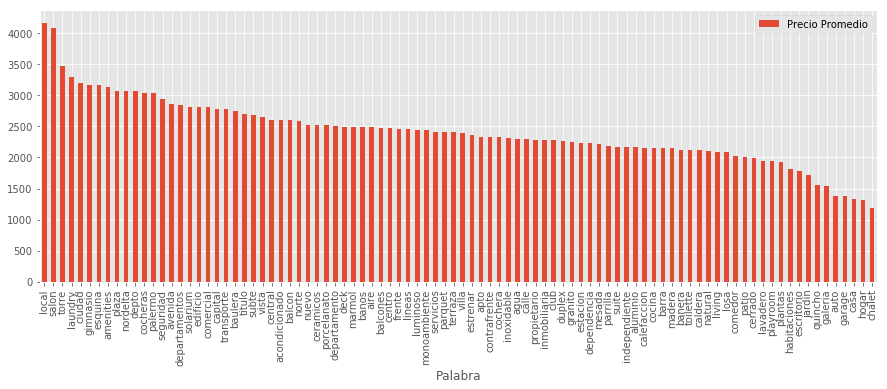

In [20]:
asd.plot(kind='bar')